# Milestone 5

**Group 186:** Jussan Da Silva Bahia Nascimento, Tim Niko, Niraj Thapaliya

# Table of Contents

1. Background and Motivation
2. Research Question
3. Dataset description
4. Data Loading and Initial Inspection
    - 4.1. Loading data
    - 4.2. Variable Types
    - 4.3. Dropping Unique id, Product id, Datetime, Timezone and Categorical weather variables
    - 4.4. Duplicate Rows
    - 4.5. Handling Product column
5. Data Missingness
6. Creating Day of the week
7. Exploring Geo and Weather variables
    - 7.1. Latitude and longitude issues
    - 7.2. Exploring Weather variables
8. Correlation Matrix for Numerical variables
9. Data Imbalance and Distributions for the Response and Categorical variables 
    - 9.1 Price
    - 9.2 Categorical variables
10. Final dataset, Baseline Model & Implementation
11. Model complexity and Final model pipeline
    - 11.1 Multilinear Regression
    - 11.2 Polynomial Regression with 2nd Degree
    - 11.3 Multilinear Regression with Interaction term
    - 11.4 Decision Tree Regressor
    - 11.5 Random Forest Regressor
    - 11.6 Gradient Boosting Regressor
    - 11.7 Model Performance
12. Final model
    - 12.1 Multicollinearity check
    - 12.2 Linearity Assumption check
    - 12.3 Performance on test data
    - 12.4 Feature importance - Permutation Importance
    - 12.5 Feature importance - Bootstrapping of Coefficient Values
    - 12.6 Conclusions
    - 12.7 Strengths, Limitations and Future improvements
14. Appendix
    - 13.1 Final dataset details

#### Import Packages

In [1]:
# Import packages
import os
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    KFold,
    GridSearchCV,
)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.base import clone

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import folium

from joblib import Memory

In [2]:
# Get start time of this notebook
notebook_start = time.time()

#### 1. Background and Motivation

In the context of urban transportation, predicting rideshare prices is a complex task influenced by various factors such as weather conditions, time of day, location, traffic patterns, and demand. Rideshare companies like Uber and Lyft use dynamic pricing models that adjust fares based on real-time conditions. Understanding how weather and other objective factors impact rideshare prices can provide valuable insights for both consumers and service providers.

#### 2. Research Question

**The goal of this project is to identify the most important factors influencing the price of Uber and Lyft rides in Boston by analyzing both rideshare data (e.g., distance, product type, surge pricing) and weather data (e.g., temperature, humidity)**. In other words, we want to find an answer to the question "What are the most important variables to determine price?"

We will use various machine learning models such as Multilinear Regression, Polynomial Regression, Decision Trees, Random Forest, and Boosting techniques to predict ride prices. To evaluate the models, we'll use cross-validation R2, a metric that shows how well the model's predictions match the actual ride prices. A higher R2 indicates better model performance, meaning the model explains more of the variation in price. We will select the best-performing model and use it to rank the features based on their importance in predicting price, helping to understand what drives pricing and providing actionable insights for optimization.

By applying this approach, we aim to uncover which variables, such as weather conditions, time of day, or distance, have the most significant impact on price, which can help rideshare companies to improve pricing strategies and resource allocation.

#### 3. Dataset description

The Kaggle Uber and Lyft Dataset for Boston, MA dataset contains two main groups of variables:

Data on individual Uber/Lyft rides (17 columns)
Daily and hourly meteorological data associated with each ride (39 columns)
There are 693071 rides in the dataset, which occurred between 2018-11-27 and 2018-12-18. All pickups and dropoffs were within twelve Boston neighborhoods/districts near downtown.

The rideshare data columns include information about the time and date, pickup and dropoff location, distance, product (Lyft vs. Uber and several classes of service for each), price, and a surge multiplier. Location data is limited to neighborhood and does not contain specific coordinates, perhaps for privacy reasons.

We think the weather data were likely joined to the rideshare data from a different source. Some of the variables appear to be hourly (temperature, humidity), while others (temperatureMin, sunriseTime) are daily. There is a lot of redundancy in these variables such as datetime columns that could have been dropped after the join.

#### 4. Data Loading and Initial Inspection

In this section we load the data from CSV and take an initial look at the columns and their types.

##### 4.1. Load data

In [3]:
# Read data
df = pd.read_csv("data/rideshare_kaggle.csv")

# Print first rows
df.head(2)

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600


We have 693071 observations and 57 variables. It's a large dataset and we'll definitely want to look for ways to reduce the number of predictors. We may also want to look at using a sample to train the models to cut down on processing time.

In [4]:
# Shape
df.shape

(693071, 57)

##### 4.2. Variable Types

Taking a look at the variables, it looks like we have two main groupings:

1. Rideshare data: all columns up through longitude (0-16)
2. Weather data: all columns starting with temperature (17-56)


In [5]:
# Info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

##### 4.3. Dropping Unique id, Product id, Datetime, Timezone and Categorical weather variables

Before we identify numeric/categorical columns, there are four columns that aren't really either. One is the ride ID. This is a unique identifier that won't be useful in our modeling, so it's dropped here. The other is datetime. We'll convert that to an actual datetime type.

In [6]:
df = df.drop(columns=["id"])
df.shape

(693071, 56)

In [7]:
# Check first rows for format
df["datetime"].head()

0    2018-12-16 09:30:07
1    2018-11-27 02:00:23
2    2018-11-28 01:00:22
3    2018-11-30 04:53:02
4    2018-11-29 03:49:20
Name: datetime, dtype: object

In [8]:
# Convert datetime column datetime
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
print(df["datetime"].head())
print(df["datetime"].min())
print(df["datetime"].max())

0   2018-12-16 09:30:07
1   2018-11-27 02:00:23
2   2018-11-28 01:00:22
3   2018-11-30 04:53:02
4   2018-11-29 03:49:20
Name: datetime, dtype: datetime64[ns]
2018-11-26 03:40:46
2018-12-18 19:15:10


There is also a column `timestamp` among the weather variables. Our assumption is that this was used in the process of joining the rideshare and weather data. Since we already have a datetime column, we don't need this and drop it here.

In [9]:
df = df.drop(columns=["timestamp"])
df.shape

(693071, 55)

Finally, `timezone` is just one number and `product_id` is rendutant as it can be replaced by the column `name` which is the name of product. Moreover, `short_summary`, `long_summary` and `icon` provide descriptions about the weather conditions, so we'll delete it as we have quantitative weather variables that we might be more interesting to leverage and we'll explore more about it in Section 7 of this notebook.

In [10]:
# Removing blank spaces from the text
df["short_summary"] = df["short_summary"].str.strip()
df["short_summary"].unique()

array(['Mostly Cloudy', 'Rain', 'Clear', 'Partly Cloudy', 'Overcast',
       'Light Rain', 'Foggy', 'Possible Drizzle', 'Drizzle'], dtype=object)

In [11]:
# Removing blank spaces from the text
df["long_summary"] = df["long_summary"].str.strip()
df["long_summary"].unique()

array(['Rain throughout the day.',
       'Rain until morning, starting again in the evening.',
       'Light rain in the morning.', 'Partly cloudy throughout the day.',
       'Mostly cloudy throughout the day.',
       'Light rain in the morning and overnight.',
       'Light rain until evening.', 'Foggy in the morning.',
       'Overcast throughout the day.', 'Possible drizzle in the morning.',
       'Rain in the morning and afternoon.'], dtype=object)

In [12]:
# Removing blank spaces from the text
df["icon"] = df["icon"].str.strip()
df["icon"].unique()

array(['partly-cloudy-night', 'rain', 'clear-night', 'cloudy', 'fog',
       'clear-day', 'partly-cloudy-day'], dtype=object)

In [13]:
df["product_id"].unique()

array(['lyft_line', 'lyft_premier', 'lyft', 'lyft_luxsuv', 'lyft_plus',
       'lyft_lux', '6f72dfc5-27f1-42e8-84db-ccc7a75f6969',
       '6c84fd89-3f11-4782-9b50-97c468b19529',
       '55c66225-fbe7-4fd5-9072-eab1ece5e23e',
       '9a0e7b09-b92b-4c41-9779-2ad22b4d779d',
       '6d318bcc-22a3-4af6-bddd-b409bfce1546',
       '997acbb5-e102-41e1-b155-9df7de0a73f2',
       '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a'], dtype=object)

In [14]:
df["name"].unique()

array(['Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black',
       'UberXL', 'Black', 'UberX', 'WAV', 'Black SUV', 'UberPool', 'Taxi'],
      dtype=object)

In [15]:
df = df.drop(
    columns=["timezone", "product_id", "long_summary", "short_summary", "icon"]
)
df.shape

(693071, 50)

##### 4.4. Duplicate Rows

Some rows have duplicate data and can be dropped.

In [16]:
df.shape

(693071, 50)

In [17]:
# Checking for duplicates
df.duplicated().sum()

np.int64(1493)

In [18]:
df = df.drop_duplicates()
df.shape

(691578, 50)

##### 4.5. Handling Product column

The dataset contains the `name` column which is the product names of Lyft and Uber. We'll change this column name to `product_name` which make easier for the user to understand the meaning of this column. Moreover, there is no specification if some product names belongs to Lyft or Uber, so we'll take advantage of the `cab_type` column that identifies if a ride was from Lyft or Uber, to identify which cab type the product name belongs to.   

In [19]:
# Change `name` column to `product_name`
df.rename(columns={"name": "product_name"}, inplace=True)
# Print unique values of `product_name` and `cab_type` columns
print(df["product_name"].unique())
print(df["cab_type"].unique())

['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool' 'Taxi']
['Lyft' 'Uber']


In [20]:
# Remove spaces
df["product_name"] = df["product_name"].str.strip()
df["product_name"] = df["product_name"].str.replace(" ", "")
df["product_name"].unique()

array(['Shared', 'Lux', 'Lyft', 'LuxBlackXL', 'LyftXL', 'LuxBlack',
       'UberXL', 'Black', 'UberX', 'WAV', 'BlackSUV', 'UberPool', 'Taxi'],
      dtype=object)

In [21]:
# Remove spaces
df["product_name"] = df["cab_type"] + "_" + df["product_name"]
df["product_name"].unique()

array(['Lyft_Shared', 'Lyft_Lux', 'Lyft_Lyft', 'Lyft_LuxBlackXL',
       'Lyft_LyftXL', 'Lyft_LuxBlack', 'Uber_UberXL', 'Uber_Black',
       'Uber_UberX', 'Uber_WAV', 'Uber_BlackSUV', 'Uber_UberPool',
       'Uber_Taxi'], dtype=object)

#### 5. Data Missingness


We're fortunate that only one column has any NaN values, and it's the response variable *price*. Approximately 8% of the observations have missing price values:

In [22]:
print("col\tmissing-count")
print()
for k, v in df.isnull().sum().items():
    if v > 0:
        print(f"{k}\t{v}")

col	missing-count

price	54542


In [23]:
# % of Null values in Prices
print(
    f"There are {100 * df["price"].isnull().sum() / df.shape[0]:.2f}% missing values in Price"
)

There are 7.89% missing values in Price


Are these values Missing Completely at Random, or is there some pattern to the missingness? We can see if there is any pattern based on the values of the categorical columns:

In [24]:
for col in df.select_dtypes(["object"]).columns:
    missing = (
        df.groupby(col)["price"].apply(lambda x: x.isna().mean() * 100).sort_values()
    )
    print(missing)
    print()

source
Financial District         7.846777
North Station              7.861144
West End                   7.864523
Northeastern University    7.881227
Beacon Hill                7.881507
Theatre District           7.886337
Haymarket Square           7.889711
Boston University          7.890902
Fenway                     7.895148
North End                  7.913494
South Station              7.914305
Back Bay                   7.914392
Name: price, dtype: float64

destination
Fenway                     7.849812
Boston University          7.856820
Haymarket Square           7.859747
South Station              7.870652
Back Bay                   7.881961
Financial District         7.885109
Beacon Hill                7.897309
North End                  7.900352
North Station              7.905638
Theatre District           7.907283
West End                   7.907875
Northeastern University    7.916912
Name: price, dtype: float64

cab_type
Lyft     0.000000
Uber    14.189346
Name: price, d

The missingness appears to be uniform across all categories except *name* and *product_id*. These two columns capture the same information (with different names) so we can ignore the product_id column (since it's less descriptive). What we see is that 100% of the rides for the Uber product called "Taxi" are missing price values. And in fact all the rides with missing price values are Uber Taxi rides:

In [25]:
df[df["price"].isna()]["product_name"].unique().item()

'Uber_Taxi'

We feel comfortable dropping these rows completely. Uber Taxi is really a different type of product than the others, which coordinates rides with local cab services. It's really an apples-to-oranges comparison as far as the pricing model, and dropping it allows us to focus on just the normal Uber and Lyft products.

In [26]:
df = df.dropna()
df.shape

(637036, 50)

#### 6. Creating Day of the week

We believe that day of the week may influence the price as the weekends may have be different from weekdays

In [27]:
# Check first rows
df["datetime"].head()

0   2018-12-16 09:30:07
1   2018-11-27 02:00:23
2   2018-11-28 01:00:22
3   2018-11-30 04:53:02
4   2018-11-29 03:49:20
Name: datetime, dtype: datetime64[ns]

In [28]:
# Convert datetime column datetime
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")

# Extract day of the week - Monday=0 and Sunday=6
df["day_of_week"] = [x.day_of_week for x in df["datetime"]]

# Delete datetime
df = df.drop(columns=["datetime"])
df.head()

,hour,day,month,source,destination,cab_type,product_name,price,distance,surge_multiplier,...,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,day_of_week
0,9,16,12,Haymarket Square,North Station,Lyft,Lyft_Shared,5.0,0.44,1.0,...,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000,6
1,2,27,11,Haymarket Square,North Station,Lyft,Lyft_Lux,11.0,0.44,1.0,...,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600,1
2,1,28,11,Haymarket Square,North Station,Lyft,Lyft_Lyft,7.0,0.44,1.0,...,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000,2
3,4,30,11,Haymarket Square,North Station,Lyft,Lyft_LuxBlackXL,26.0,0.44,1.0,...,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800,4
4,3,29,11,Haymarket Square,North Station,Lyft,Lyft_LyftXL,9.0,0.44,1.0,...,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800,3


#### 7. Exploring Geo and Weather variables

##### 7.1. Latitude and longitude issues

Originally we thought the latitude and longitude might be the exact coordinates of either the pickup or dropoff location. Even though the column is numeric, there are only twelve unique coordinate locations. Since there are also twelve unique values for the source and destination variables (which are Boston neighborhoods or districts), it seems likely that the lat/long pairs are just coordinates (such as centroid) for each of those areas. It's not surprising that there wouldn't be exact locations since that could be a privacy issue. 

In [29]:
uniq_coords = df[["latitude", "longitude"]].drop_duplicates()
uniq_coords

,latitude,longitude
0,42.2148,-71.0330
6,42.3503,-71.0810
12,42.3647,-71.0542
19,42.3661,-71.0631
25,42.3588,-71.0707
76,42.3505,-71.1054
91,42.3429,-71.1003
96,42.3519,-71.0551
112,42.3519,-71.0643
120,42.3644,-71.0661


What's especially odd though is that there isn't a one-to-one correspondence between a source/destination and a particular lat/long pair. Here we show the counts for lat/long pairs for each source. There's a similar pattern for destination though it's not shown here. The lat/long pairs appear to be scrambled.

In [30]:
for source in df["source"].unique():
    print(f"\n{source}:")
    coords = df[df["source"] == source][["latitude", "longitude"]].drop_duplicates()
    print(coords.sort_values(["latitude", "longitude"]))


Haymarket Square:
     latitude  longitude
0     42.2148   -71.0330
359   42.3398   -71.0892
861   42.3429   -71.1003
389   42.3503   -71.0810
300   42.3505   -71.1054
398   42.3519   -71.0643
225   42.3519   -71.0551
859   42.3559   -71.0550
399   42.3588   -71.0707
228   42.3644   -71.0661
224   42.3647   -71.0542
387   42.3661   -71.0631

Back Bay:
      latitude  longitude
153    42.2148   -71.0330
778    42.3398   -71.0892
420    42.3429   -71.1003
6      42.3503   -71.0810
154    42.3505   -71.1054
261    42.3519   -71.0643
893    42.3519   -71.0551
1161   42.3559   -71.0550
174    42.3588   -71.0707
774    42.3644   -71.0661
418    42.3647   -71.0542
151    42.3661   -71.0631

North End:
     latitude  longitude
68    42.2148   -71.0330
612   42.3398   -71.0892
179   42.3429   -71.1003
182   42.3503   -71.0810
193   42.3505   -71.1054
349   42.3519   -71.0643
743   42.3519   -71.0551
655   42.3559   -71.0550
64    42.3588   -71.0707
200   42.3644   -71.0661
12    42.3647   -71.

A second problem is that one of the lat/long pairs is not anywhere near the others and doesn't appear to match any of the areas in the source/destination variables. It's all the way down in Braintree!

In [31]:
boston_map = folium.Map(tiles="OpenStreetMap")

for idx, row in uniq_coords.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        color="black",
        radius=8,
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color="green",
        popup=f"Lat: {row['latitude']:.4f}, Long: {row['longitude']:.4f}",
    ).add_to(boston_map)

boston_map.fit_bounds(boston_map.get_bounds(), padding=(40, 40))
boston_map

In light of this we will drop the latitude and longitude columns:

In [32]:
df = df.drop(columns=["latitude", "longitude"])
df.shape

(637036, 48)

##### 7.2. Exploring Weather variables

As we can observe below, there are 26 out of 37 weather variables with that are high correlated to each other (correlation >= 0.9). Moreover, the weather variables has very low correlated with price. There is also redundancy as, for example, there are 19 variations of temperature (e.g apparentTemperature, temperatureLow...). And we don't believe that uvIndex, ozone and moonPhase would impact the ride price. Therefore we decided to keep few weather variables to elimate rendundacy and that we believe it can somehow impact price which is Temperature, Precipitation Probability and Wind speed. In the case we do not find model(s) with good performance (e.g R2 > 0.9), we can come back to this step and add more weather variables to the final dataset.

In [33]:
weather_num_col = [
    "temperature",
    "apparentTemperature",
    "precipIntensity",
    "precipProbability",
    "humidity",
    "windSpeed",
    "windGust",
    "windGustTime",
    "visibility",
    "temperatureHigh",
    "temperatureHighTime",
    "temperatureLow",
    "temperatureLowTime",
    "apparentTemperatureHigh",
    "apparentTemperatureHighTime",
    "apparentTemperatureLow",
    "apparentTemperatureLowTime",
    "dewPoint",
    "pressure",
    "windBearing",
    "cloudCover",
    "uvIndex",
    "visibility.1",
    "ozone",
    "sunriseTime",
    "sunsetTime",
    "moonPhase",
    "precipIntensityMax",
    "uvIndexTime",
    "temperatureMin",
    "temperatureMinTime",
    "temperatureMax",
    "temperatureMaxTime",
    "apparentTemperatureMin",
    "apparentTemperatureMinTime",
    "apparentTemperatureMax",
    "apparentTemperatureMaxTime",
]

In [34]:
weather_num_col_with_price = weather_num_col + ["price"]

In [35]:
# Get correlations from numerical columns
corr_matrix_weather = df[weather_num_col_with_price].corr().abs()

# select the pairs with correlation equal or higher than 0.9
high_corr_pairs = (
    corr_matrix_weather.where(
        np.triu(np.ones(corr_matrix_weather.shape), k=1).astype(bool)
    )
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] >= 0.9]

high_corr_pairs_features = list(high_corr_pairs["Feature1"])
high_corr_pairs_features.extend(high_corr_pairs["Feature2"])
np.unique(high_corr_pairs_features)

array(['apparentTemperature', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'sunriseTime', 'sunsetTime',
       'temperature', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'temperatureMax',
       'temperatureMaxTime', 'temperatureMin', 'temperatureMinTime',
       'uvIndexTime', 'visibility', 'visibility.1', 'windGust',
       'windGustTime', 'windSpeed'], dtype='<U27')

In [36]:
# length of high correlated weather variables
len(np.unique(high_corr_pairs_features))

26

In [37]:
# length of weather columns
len(weather_num_col)

37

In [38]:
# Get weather variable correlations with price
corr_price_weather = corr_matrix_weather["price"].abs().sort_values(ascending=False)
corr_price_weather

price                          1.000000
moonPhase                      0.001491
visibility.1                   0.001483
visibility                     0.001483
windBearing                    0.001325
windGust                       0.001262
humidity                       0.001220
precipIntensityMax             0.001096
windSpeed                      0.001033
cloudCover                     0.000861
apparentTemperatureLow         0.000821
windGustTime                   0.000731
pressure                       0.000707
apparentTemperatureMinTime     0.000692
temperatureMinTime             0.000651
temperatureMaxTime             0.000648
uvIndexTime                    0.000645
apparentTemperatureLowTime     0.000644
sunsetTime                     0.000642
sunriseTime                    0.000642
temperatureHighTime            0.000641
temperatureLowTime             0.000637
apparentTemperatureMaxTime     0.000629
dewPoint                       0.000625
apparentTemperatureHighTime    0.000623


In [39]:
# Change `precipProbability` to `precipitationProbability`
df.rename(columns={"precipProbability": "precipitationProbability"}, inplace=True)
# Weather features
weather_features = ["temperature", "precipitationProbability", "windSpeed"]
df[weather_features].head()

,temperature,precipitationProbability,windSpeed
0,42.34,0.0,8.66
1,43.58,1.0,11.98
2,38.33,0.0,7.33
3,34.38,0.0,5.28
4,37.44,0.0,9.14


#### 8. Correlation Matrix for Numerical variables

When two or more features are highly correlated, also know as collinearity, they provide essentially the same information to the model. This redundancy can make it difficult for the model to distinguish the independent effects of each variable. It also increases the variance of the estimated coefficients, leading to a decrease in the model’s precision.

We correlated all predictors with each other and we do not identify any highly correlated pairs as we did before with the weather variables. 

Distance and surge multiplier have the highest correlations with price as shown below. It's not surprising that these are correlated with the ride price, but we would hope to find other relationships in the course of this study. Perhaps due to the winter, it makes sense that there is no strong correlation between weather and price as the low temperatures of this season. This is an important finding because we'll consider those two features for our baseline model due to their correlation with price. 

In [40]:
# Function to add spaces before capital letters and capitalize words - For Visualization purposes
def format_feature_name(name):
    # Add space before capital letters and capitalize first letter of each word
    name = re.sub(r"([a-z])([A-Z])", r"\1 \2", name)

    # Replace underscores with spaces, then capitalize
    name = name.replace("_", " ").title()

    return name

In [41]:
# Set the categorical, numerical features and predictor
# Categorical features
categorical_features = [
    "hour",
    "day",
    "month",
    "source",
    "destination",
    "cab_type",
    "product_name",
    "day_of_week",
]

# Numerical features
numerical_features = ["distance", "surge_multiplier"]

numerical_features = numerical_features + weather_features

# Response
response = ["price"]

# Numerical Features + Price
numerical_features_response = numerical_features + response
print(numerical_features_response)

# All predictors
predictors = numerical_features + categorical_features
print("\n")
print(predictors)

['distance', 'surge_multiplier', 'temperature', 'precipitationProbability', 'windSpeed', 'price']


['distance', 'surge_multiplier', 'temperature', 'precipitationProbability', 'windSpeed', 'hour', 'day', 'month', 'source', 'destination', 'cab_type', 'product_name', 'day_of_week']


In [42]:
# Compute the correlation matrix
corr = df[numerical_features_response].corr()

# Apply format_feature_name() to column labels (features)
corr.columns = corr.columns.map(format_feature_name)

# Apply format_feature_name() to index labels (rows)
corr.index = corr.index.map(format_feature_name)

corr

,Distance,Surge Multiplier,Temperature,Precipitation Probability,Wind Speed,Price
Distance,1.000000,0.025903,-0.002749,0.000172,0.001736,0.345110
Surge Multiplier,0.025903,1.000000,-0.001581,-0.002796,0.002631,0.240549
Temperature,-0.002749,-0.001581,1.000000,0.239062,0.058745,-0.000113
Precipitation Probability,0.000172,-0.002796,0.239062,1.000000,0.251854,-0.000233
Wind Speed,0.001736,0.002631,0.058745,0.251854,1.000000,0.001033
Price,0.345110,0.240549,-0.000113,-0.000233,0.001033,1.000000


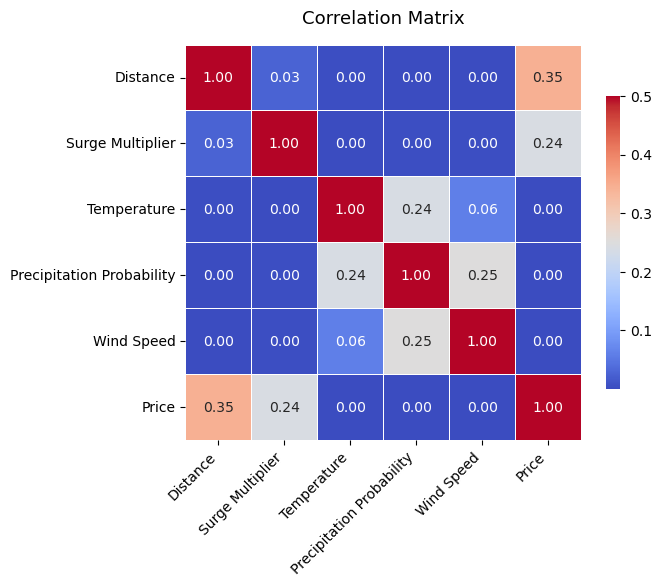

In [43]:
# Plot the heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(
    corr.abs(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    vmax=0.5,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.5},
)

# Title and layout adjustments
plt.title("Correlation Matrix", fontsize=13, pad=15)
# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### 9. Data Imbalance and Distributions for the Response and Categorical variables

##### 9.1 Price 

As mentioned above, the response variable is quantitative, so we cannot have class imbalance in the response as we would if this were a classification problem. We do notice that the distribution of `price` has some right skew, which is not surprising for price data. The skewness does not appear to be extreme, but we can nudge adjust the distribution more towards 'normal' when we scale the price in Log scale. This suggests to us that the Price values naturally follow a lognormal distribution.

In [44]:
# Get log of price
df["log_price"] = np.log10(df.price)
df[["price", "log_price"]].describe()

,price,log_price
count,637036.000000,637036.000000
mean,16.548093,1.150846
std,9.325947,0.247036
min,2.500000,0.397940
25%,9.000000,0.954243
50%,13.500000,1.130334
75%,22.500000,1.352183
max,97.500000,1.989005


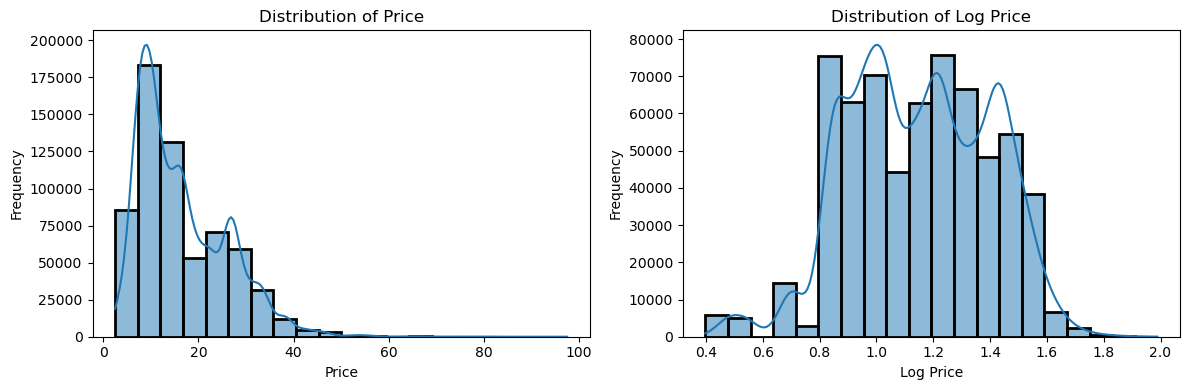

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# Plot histogram and density curve for 'price'
sns.histplot(
    df["price"], kde=True, bins=20, ax=axs[0], linewidth=2, kde_kws={"bw_adjust": 2.5}
)
axs[0].set_title("Distribution of Price")
axs[0].set_xlabel("Price")
axs[0].set_ylabel("Frequency")

# Plot histogram and density curve for 'log_price'
sns.histplot(
    df["log_price"],
    kde=True,
    bins=20,
    ax=axs[1],
    linewidth=2,
    kde_kws={"bw_adjust": 2.5},
)
axs[1].set_title("Distribution of Log Price")
axs[1].set_xlabel("Log Price")
axs[1].set_ylabel("Frequency")

# Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()

##### 9.2 Predictor variables

What about the distributions of the predictor variables? Here we come to a surprising find and one that causes some concern for this project.

We see strangely uniform distributions for some variables. Here are four examples. Of these, hour is least uniform, and yet it's a surprising pattern that doesn't match our expectations about when people ride. Note the almost exact uniformity in rides between 10am and 6pm.

The distribution of the other three variables is no less surprising. We would expect some neighborhoods to have more rides, either source or destination, than others. We would also expect variation in the different values of the "name" variable, representing different classes of ride. There should probably be more standard Lyft riders, for instance, than Lyft Lux Black. 

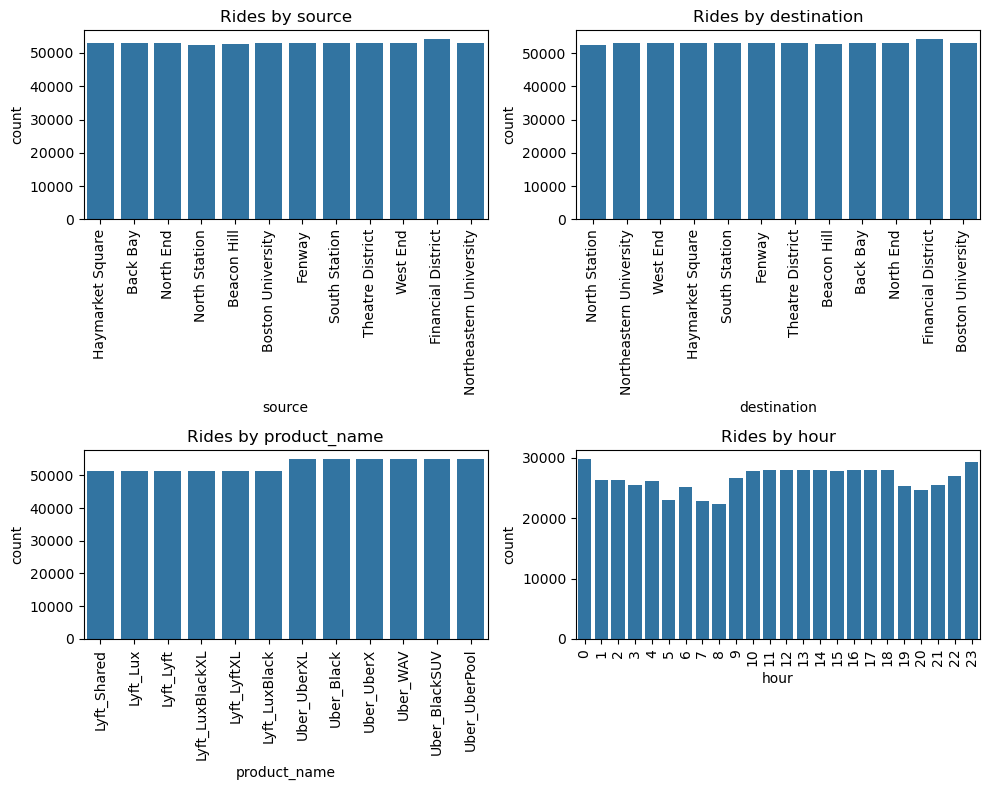

In [46]:
cols = ["source", "destination", "product_name", "hour"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axs.ravel(), cols):
    sns.countplot(df, x=col, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Rides by " + col)
plt.tight_layout()

Another surprising finding is the pattern of source-destination pairs. Half of the pairs have exactly zero rides, and the other half have a distribution that is roughly uniform with ride counts in the high 8000s to mid 9000s. This does not match what we would expect in real life, where we would expect a positive value in almost all pairs, and a lot more variation with some pairs having high counts, some low, some in between. A possible explanation is that the data was sampled from the original data source due to Uber's and Lyft's privacy concerns.

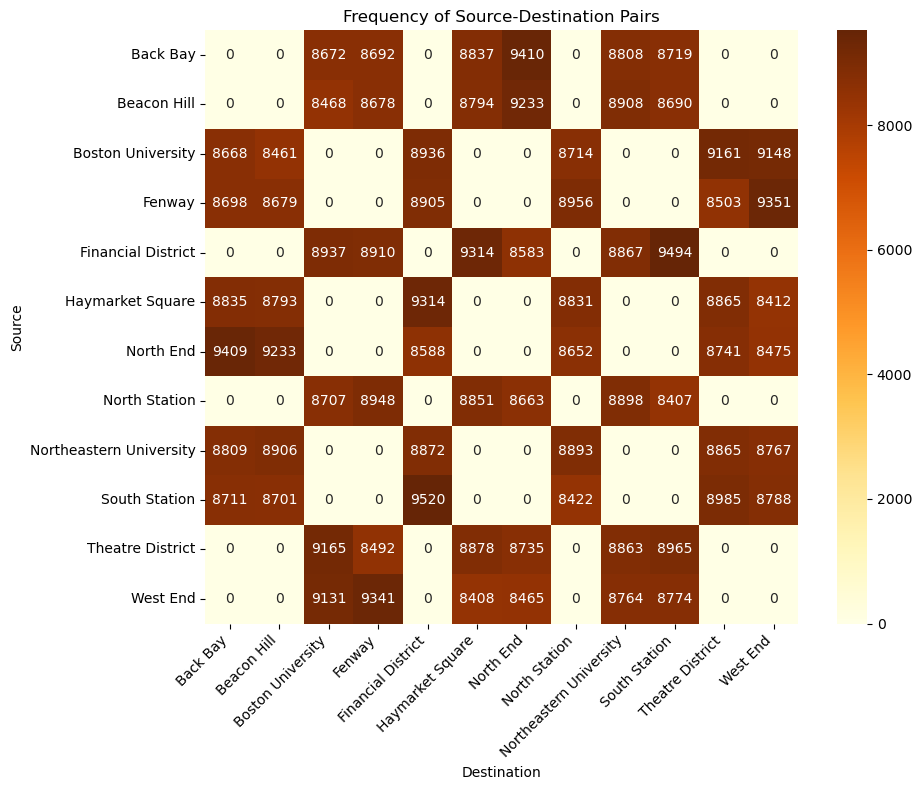

In [47]:
sd_pairs = pd.crosstab(df["source"], df["destination"])
plt.figure(figsize=(10, 8))
sns.heatmap(sd_pairs, annot=True, fmt="d", cmap="YlOrBr", square=True)
plt.title("Frequency of Source-Destination Pairs")
plt.xlabel("Destination")
plt.ylabel("Source")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Here is look at the distributions of the variables. One item to note is that one of the predictors that we might expect to have the most impact on price, surge_multiplier, has almost all rides with the default value 1.0.

Another insight is that variables as month and day_of_the_week are ordinal variables so we'll keep it as categorical variables. 

We can also observe that the dataset has only two months end of the year (November and December) which corresponds the end of year and winter season. Therefore, it might make sense that we expect low temperatures as we can observe in temperature which show temperature no higher than 60F (15.5C).

Based on the chart above we can check all categorical variables and all numerical variables

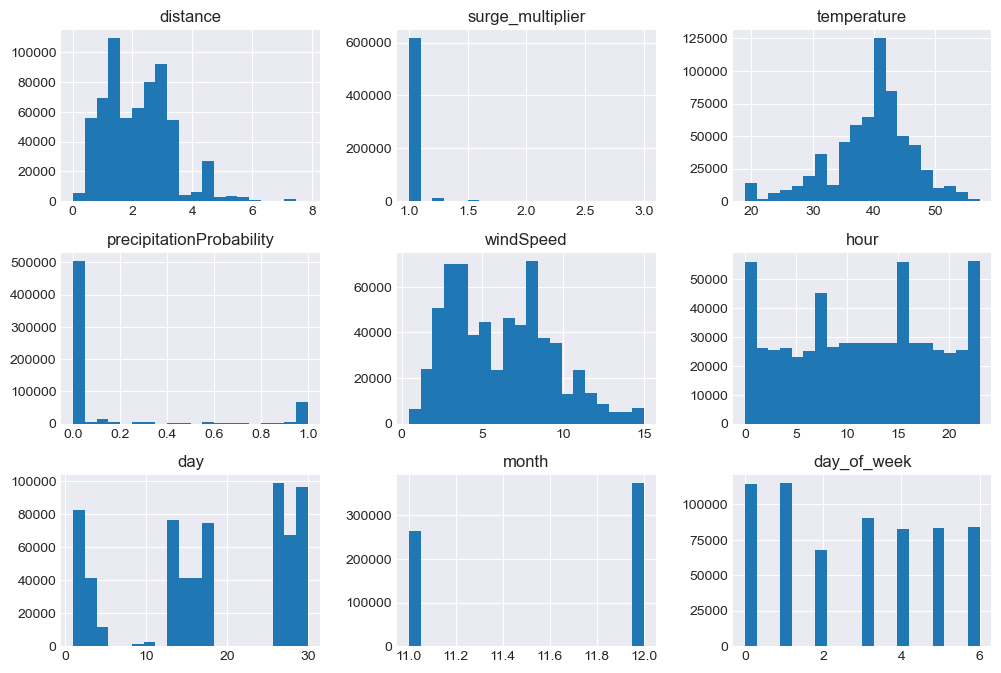

In [48]:
# Here we look at the distribution of numerical features
style.use("seaborn-v0_8-darkgrid")
df[predictors].hist(figsize=(12, 8), bins=20)
plt.show()

We can observe in the boxplots below that there are some changes in the median price based on the the different `source` and `destination`. We can also observe that depending on the product (`product_name`) used in the trip, price changes which is expected as we know that an UberBlack is normally more expensive than UberX, for example. We can also see that there is a slight in median price between Uber and Lyft which also expected as they are different companies that uses different ways to charge the user. So those may be good predictors of price, in addition to distance and surge multiplier, and it may improve the performance of price's prediction model compared to the baseline. Nevertheless, the `price` does not seem to change based based on `hour`, `month` or `day_of_week`.

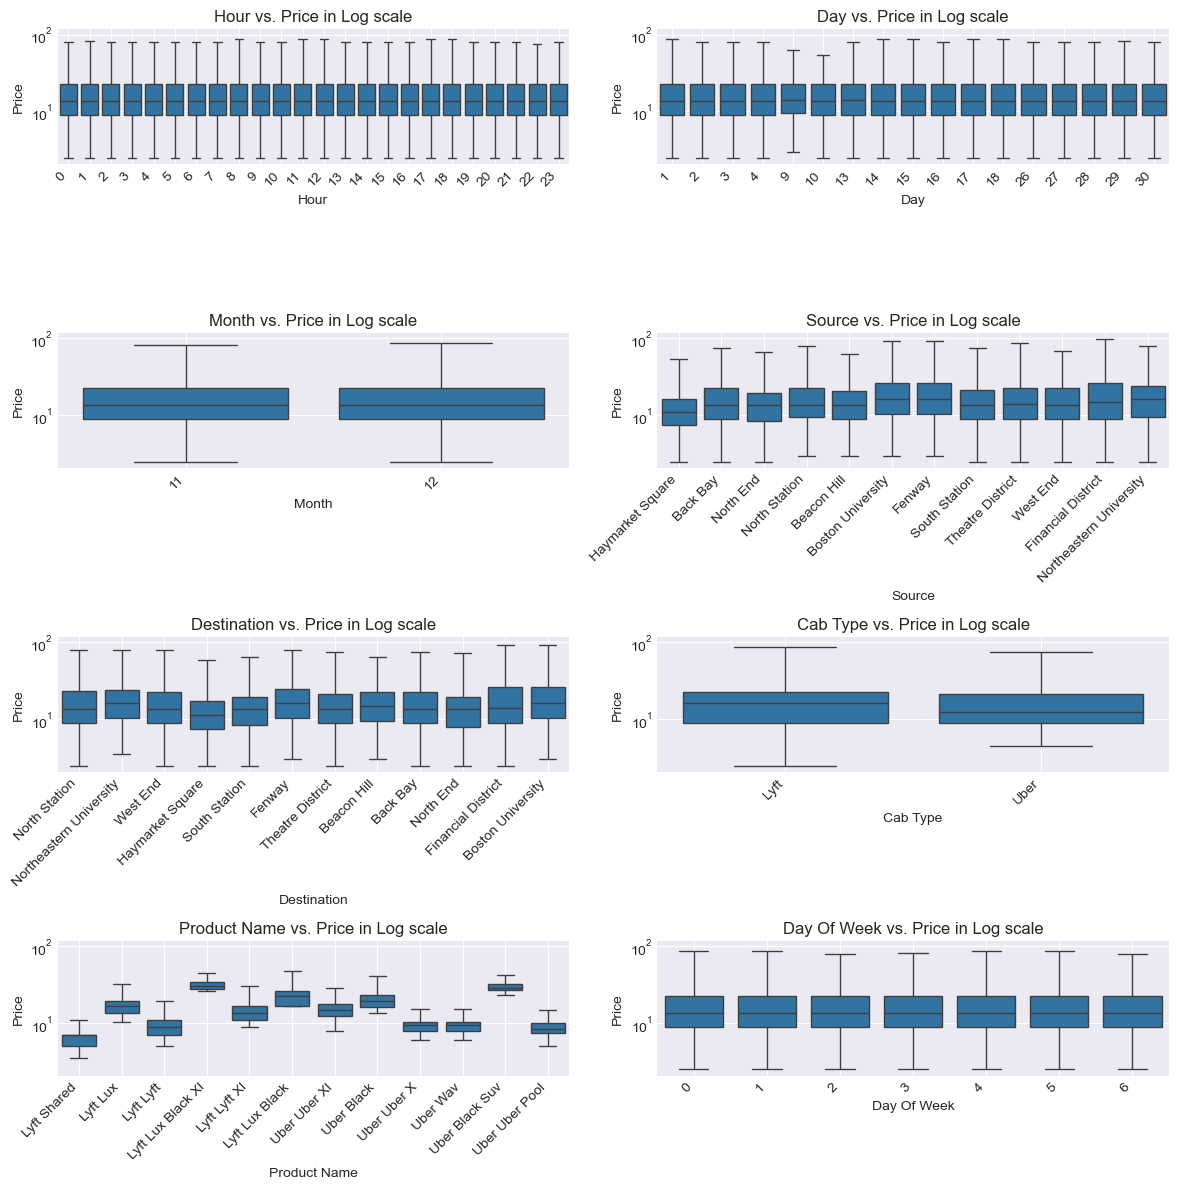

In [49]:
# Apply format_column_name() on df and categorical features
df_box_plot = df.copy()
df_box_plot.columns = [format_feature_name(col) for col in df_box_plot.columns]
categorical_features_box_plot = [
    format_feature_name(pos) for pos in categorical_features
]

# Apply the format_column_name function to each value in the 'Product Name'
df_box_plot["Product Name"] = df_box_plot["Product Name"].apply(format_feature_name)


# Boxplots with categorical variables
fig, axes = plt.subplots(
    nrows=int(len(categorical_features_box_plot) / 2), ncols=2, figsize=(12, 12)
)
# flatted the axes array to 1D
axes = axes.ravel()
# iterate over pairs of column names and axes
for c, ax in zip(categorical_features_box_plot, axes):
    # Use pandas' plot functionality
    sns.boxplot(x=c, y="Price", data=df_box_plot, ax=ax, fliersize=0, log_scale=True)
    ax.set_title(f"{c} vs. Price in Log scale")
    # Rotate x-axis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    # Add grid
    ax.grid(True)

# add some padding between subplots
plt.tight_layout()

plt.show()

#### 10. Final dataset, Baseline Model & Implementation

We have a final dataset containing the price and 13 features (5 numerical and 8 categorical variables). In the appendix, under Final dataset details, one can find the description of each column. Our modeling approach follows an incremental complexity design, initiating with fundamental statistical methods before progressing to more sophisticated techniques. The foundational (baseline) implementation employs a multilinear regression model to establish baseline performance metrics considering the two highest correlated variables to price: distance and surge multiplier. The dataset will be split into 80% training set and 20% test set. We'll implement a k-fold cross-validation (CV) in the training set to get and compare the CV Mean Squared Error (MSE) and R^2 across the models. We also expect to apply feature engineering process as scale or normalize numeric variables and one-hot encode categorical variables throughout the process of testing more complex models. 

In [50]:
def get_performance_metrics(model, X_train, y_train, kf, n_jobs):
    # Perform cross-validation for MSE and R2

    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=kf,
        n_jobs=n_jobs,
        scoring=["neg_mean_squared_error", "r2"],
    )

    # Calculate the average CV metrics
    cv_mean_mse = -1 * np.mean(scores["test_neg_mean_squared_error"])
    cv_r2_mean = np.mean(scores["test_r2"])

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predictions on train set
    y_train_pred = model.predict(X_train)

    # Calculate Train and Test MSE and R2
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print("Train MSE:", round(train_mse, 4))
    print("Mean CV MSE:", round(cv_mean_mse, 4))
    print("Train R^2:", round(train_r2, 4))
    print("Mean CV R^2:", round(cv_r2_mean, 4))

    return {
        "train_mse": train_mse,
        "cv_mean_mse": cv_mean_mse,
        "train_r2": train_r2,
        "cv_r2_mean": cv_r2_mean,
    }

In [51]:
# Setting up some common variables
random_state = 0
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
n_jobs = -1
n_estimators = 30

In [52]:
# Assign log_price to response
response = ["log_price"]

# Checking response predictors
print("Response:")
print(response)
print("\nNumerical features:")
print(numerical_features)
print("\nCategorical features:")
print(categorical_features)
print("\nAll features:")
print(predictors)

Response:
['log_price']

Numerical features:
['distance', 'surge_multiplier', 'temperature', 'precipitationProbability', 'windSpeed']

Categorical features:
['hour', 'day', 'month', 'source', 'destination', 'cab_type', 'product_name', 'day_of_week']

All features:
['distance', 'surge_multiplier', 'temperature', 'precipitationProbability', 'windSpeed', 'hour', 'day', 'month', 'source', 'destination', 'cab_type', 'product_name', 'day_of_week']


In [53]:
display(df[response + predictors].head())
print(df[response + predictors].head().shape)
print(df[response + predictors].head().info())

,log_price,distance,surge_multiplier,temperature,precipitationProbability,windSpeed,hour,day,month,source,destination,cab_type,product_name,day_of_week
0,0.698970,0.44,1.0,42.34,0.0,8.66,9,16,12,Haymarket Square,North Station,Lyft,Lyft_Shared,6
1,1.041393,0.44,1.0,43.58,1.0,11.98,2,27,11,Haymarket Square,North Station,Lyft,Lyft_Lux,1
2,0.845098,0.44,1.0,38.33,0.0,7.33,1,28,11,Haymarket Square,North Station,Lyft,Lyft_Lyft,2
3,1.414973,0.44,1.0,34.38,0.0,5.28,4,30,11,Haymarket Square,North Station,Lyft,Lyft_LuxBlackXL,4
4,0.954243,0.44,1.0,37.44,0.0,9.14,3,29,11,Haymarket Square,North Station,Lyft,Lyft_LyftXL,3


(5, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   log_price                 5 non-null      float64
 1   distance                  5 non-null      float64
 2   surge_multiplier          5 non-null      float64
 3   temperature               5 non-null      float64
 4   precipitationProbability  5 non-null      float64
 5   windSpeed                 5 non-null      float64
 6   hour                      5 non-null      int64  
 7   day                       5 non-null      int64  
 8   month                     5 non-null      int64  
 9   source                    5 non-null      object 
 10  destination               5 non-null      object 
 11  cab_type                  5 non-null      object 
 12  product_name              5 non-null      object 
 13  day_of_week               5 non-null      int64  
dtypes: float64(

In [54]:
# Set X as all features except 'price' and y as the target
X = df[predictors]
y = df["log_price"]

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((509628, 13), (127408, 13), (509628,), (127408,))

In [55]:
# Save training and test sets so the team can test different models separately
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
print("csv files saved")

csv files saved


In [56]:
# Assign distance and surge_multiplier features to train and test set to build the baseline model
X_train_baseline = X_train[["distance", "surge_multiplier"]]
X_test_baseline = X_test[["distance", "surge_multiplier"]]
X_train_baseline.shape, X_test_baseline.shape

((509628, 2), (127408, 2))

In [57]:
# Check first rows of X train and test sets
display(X_train_baseline.head())
display(X_test_baseline.head())

,distance,surge_multiplier
30854,1.61,1.0
671433,2.84,1.0
37044,1.89,1.0
448026,4.40,1.0
334912,3.04,1.0


,distance,surge_multiplier
579727,1.74,1.0
601334,3.37,1.0
391039,1.83,1.0
484045,2.32,1.0
619761,4.72,1.0


In [58]:
# Initialize the model
baseline_model = LinearRegression()

# Get performance metrics for the baseline model
performance_metrics_baseline = get_performance_metrics(
    baseline_model, X_train_baseline, y_train, kf, n_jobs
)

Train MSE: 0.0522
Mean CV MSE: 0.0522
Train R^2: 0.1439
Mean CV R^2: 0.1439


#### 11. Model complexity

Our modeling approach follows an incremental complexity design, initiating with fundamental statistical methods before progressing to more sophisticated techniques. The foundational implementation, as shown previously, employs a multilinear regression model with the most correlated (numerical) variables (distance and surge multiplier) to establish baseline performance metrics. The implementation strategy prioritizes model interpretability while progressively incorporating complexity in the models to try to enhance predictive accuracy (Cross-Validation R2) as shown below. Moreover, we decided to decided to use Pipeline package from sklearn as it prevents leakage and it's a powerful tool for chaining multiple steps of data processing and modeling. it offer several advantages such as:

- Simplification: Combine preprocessing, feature selection, and modeling in a single object.
- Consistency: Apply the same steps to training and test data, preventing data leakage.
- Convenience: Fit and predict on the entire workflow with a single call.
- Grid Search: Easily perform cross-validation across all parameters in the pipeline. We also added a Catching method in the Pipeline so it doesn't transform data each step in the of search/fit. This may save a lot of time while testing different hyperparameter combinations.

Furthermore, our strategy is to test different models in a simple way (not fine tuning) to give us an understanding of the performance of each model. Once we select the best model, we can try to improve its performance with hyperparameter tuning. 

##### 11.1 Multilinear Regression 

Multilinear regression is a statistical technique used to model the relationship between one dependent variable and two or more independent variables ( as in our case) by fitting a linear equation to the observed data. Here's the Pros and Cons of this model:

Pros:
- Simple and interpretable: Provides a straightforward way to understand relationships between variables.
- Efficient: Computationally inexpensive and easy to implement.
- Predictive power: Works well if assumptions (linearity, normality, etc.) are met.

Cons:
- Sensitive to outliers: Can be skewed by extreme values.
- Assumption-dependent: Requires linearity, normality of residuals, no multicollinearity, and homoscedasticity.
- Limited complexity: Cannot capture non-linear relationships unless explicitly transformed.

As our primarily goal is the prediction performance we are interested on the Cross-validated R2 (CV R2). 

In terms of the model's implementation, we one-hot encoded the non dummy categorical variables dropping the first column of each transformed dummy variable as N categories should be converted to N-1 binary and mutually exclusive columns. We also scaled the numerical features, even it's not necessary for multilinear regression, but it will be for Polynomial features (degree = 2) and penalization terms from Ridge and Lasso regression.

Looking at the performance metrics of the model, we can observe that the Multilinear regression model has a high mean CV R2 of 0.9385 which make it a good candidate for our final model. Moreover, it has much higher CV R2 (almost 7x) compared to our baseline model, with CV R2 equals to 0.1439.

In [59]:
# Numeric features pipeline
numerical_pipeline_mlr = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

# Categorical features pipeline
categorical_pipeline_mlr = Pipeline(
    [("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))]
)

# Combine preprocessing steps
preprocessor_mlr = ColumnTransformer(
    [
        ("num", numerical_pipeline_mlr, numerical_features),
        ("cat", categorical_pipeline_mlr, categorical_features),
    ]
)

# Define Pipeline for Multilinear regression
pipe_mlr = Pipeline(
    [
        ("preprocessor", preprocessor_mlr),
        ("regressor", LinearRegression(n_jobs=n_jobs)),
    ],
)

# Print Pipeline
pipe_mlr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor', LinearRegression(n_jobs=-1))])

In [60]:
# Get performance metrics for the MLR model
performance_metrics_mlr = get_performance_metrics(
    pipe_mlr, X_train, y_train, kf, n_jobs
)

Train MSE: 0.0037
Mean CV MSE: 0.0037
Train R^2: 0.9386
Mean CV R^2: 0.9385


##### 11.2 Polynomial Regression with 2nd Degree

Polynomial regression extends linear regression by fitting a curve to the data, using polynomial terms (quadratic as in our case) to model non-linear relationships.

Pros:
- Captures Non-Linear Trends: Useful for relationships that aren't strictly linear.
- Simple to Implement: Easily adapted from linear regression frameworks.
- Interpretability: Still relatively straightforward compared to higher-degree models.
  
Cons:
- Prone to Overfitting: May overfit if unnecessary higher-degree terms are included (increase of complexity).
- Limited Flexibility: Only models a specific type of non-linearity (quadratic in our case).
- Sensitive to Outliers: Like linear regression, it's affected by extreme values.

We scale the numerical features so we can apply Polynomial features (degree = 2) preventing under- and over-flow problems when taking predictors to high degrees. As for the Multilinear regression, we one-hot encoded the categorical features. 

Looking at the performance metrics of the model, we can observe that the the Polynomial regression model has a high mean CV R2 of 0.941 but very close to the one obtained with the Multilinear regression model even if there is a slight improvement. 

In [61]:
# Numeric features pipeline
numerical_pipeline_poly = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "polynomial",
            PolynomialFeatures(include_bias=False, degree=2),
        ),
    ]
)

# Categorical features pipeline
categorical_pipeline_poly = Pipeline(
    [("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))]
)

# Combine preprocessing steps
preprocessor_poly = ColumnTransformer(
    [
        ("num", numerical_pipeline_poly, numerical_features),
        ("cat", categorical_pipeline_poly, categorical_features),
    ]
)

# Define Pipeline for Linear Regression with Polynomial features
pipe_poly = Pipeline(
    [
        ("preprocessor", preprocessor_poly),
        ("regressor", LinearRegression(n_jobs=n_jobs)),
    ],
)

# Print Pipeline
pipe_poly

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor', LinearRegression(n_jobs=-1))])

In [62]:
# Get performance metrics for the 2nd Degree Polynomial model
performance_metrics_poly = get_performance_metrics(
    pipe_poly, X_train, y_train, kf, n_jobs
)

Train MSE: 0.0036
Mean CV MSE: 0.0036
Train R^2: 0.941
Mean CV R^2: 0.941


##### 11.3 Multilinear Regression with Interaction term

Adding interaction terms to multilinear regression allows the model to capture relationships where the effect of one independent variable on the dependent variable depends on another independent variable. It can be useful when predictors have synergistic effects, leading to better prediction accuracy.

Pros:
- Enhanced Flexibility: Goes beyond simple additive relationships without needing a fully non-linear model.
- Interpretability: Still easier to explain compared to black-box models like decision trees or boosting.

Cons:
- Increased Complexity: More terms make the model harder to interpret and prone to overfitting.
- Multicollinearity Risk: Interaction terms can introduce high correlations with main effects, complicating coefficient estimation.
- Assumes Linear Interaction: Still assumes a linear relationship in the interaction, limiting flexibility compared to non-linear models.

For the same reason as polynomial, we scale the numerical features, as interaction terms amplify the effects of magnitude differences between features. We also one-hot encoded the categorical variables.

Looking at the performance metrics of the model, we can observe that the the Multilinear regression with Interaction term has a high mean CV R2 of 0.9386 but is the same one obtained with the Multilinear regression model.

In [63]:
# Numeric features pipeline
numerical_pipeline_interaction = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "polynomial",
            PolynomialFeatures(include_bias=False, interaction_only=True),
        ),
    ]
)

# Categorical features pipeline
categorical_pipeline_interaction = Pipeline(
    [("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))]
)

# Combine preprocessing steps
preprocessor_interaction = ColumnTransformer(
    [
        ("num", numerical_pipeline_interaction, numerical_features),
        ("cat", categorical_pipeline_interaction, categorical_features),
    ]
)

# Define Pipeline for Linear Regression with interaction terms
pipe_interaction = Pipeline(
    [
        ("preprocessor", preprocessor_interaction),
        ("regressor", LinearRegression(n_jobs=n_jobs)),
    ],
)

# Print Pipeline
pipe_interaction

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor', LinearRegression(n_jobs=-1))])

In [64]:
# Get performance metrics for the Multilinear Regression with Interaction term
performance_metrics_interaction = get_performance_metrics(
    pipe_interaction, X_train, y_train, kf, n_jobs
)

Train MSE: 0.0037
Mean CV MSE: 0.0037
Train R^2: 0.9386
Mean CV R^2: 0.9386


##### 11.4 Decision Tree Regressor

Decision tree regression is a non-linear regression technique that uses a tree-like model to split the data into regions based on feature values, making predictions as the average outcome within each region. We decided to use this technique to see if our model can can capture non-linear patterns relationship between the features and price. 

Pros:
- Captures Non-Linear Relationships: No assumptions about linearity.
- Interpretability: Easy to visualize and interpret results.
- No Need for Scaling: Simplifies preprocessing.

Cons:
- Prone to Overfitting: Can create overly complex trees.
- Instability: Small changes in data can lead to different splits.

Decision trees have some nice properties when it comes to preprocessing as we don't need to scale the data as Trees don't require feature scaling because they use thresholds rather than distances. Moreover, Trees make splits based on relative ordering, not absolute values. In terms of Categorical variables, for binary categories, any encoding works equally well but for multi-class categories one-hot encoding is preferred but we don't use drop_first (unlike linear models) since trees can handle the redundancy. In terms of parameters, we decided to limit the max_depth (the maximum depth of the tree) from None, as the default, to 10 after some tests. 

Looking at the performance metrics of the model, we can observe that the Decision tree model has a high mean CV R2 of 0.9354 which is slightly lower than the one obtained with the Multilinear regression model. However, there might be a potential performance improvement if we tune the hyperparameters. 

In [65]:
# Categorical features pipeline
categorical_pipeline_dt = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Combine preprocessing steps
preprocessor_dt = ColumnTransformer(
    [
        ("num", "passthrough", numerical_features),
        ("cat", categorical_pipeline_dt, categorical_features),
    ]
)

# Define Pipeline for Decision Tree Regressor
pipe_dt = Pipeline(
    [
        ("preprocessor", preprocessor_dt),
        ("regressor", DecisionTreeRegressor(max_depth=10, random_state=random_state)),
    ],
)

# Print Pipeline
pipe_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=10, random_state=0))])

In [66]:
# Get performance metrics for the Decision Tree Regression
performance_metrics_dt = get_performance_metrics(pipe_dt, X_train, y_train, kf, n_jobs)

Train MSE: 0.0038
Mean CV MSE: 0.0039
Train R^2: 0.9376
Mean CV R^2: 0.9354


##### 11.5 Random Forest Regressor

Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to improve accuracy and reduce overfitting. In regression, it averages the predictions from individual trees. It's a powerful machine learning model with the main features as explained below:

- Ensemble of Decision Trees: Builds many decision trees using random subsets of data and features.
- Bootstrap Aggregating (Bagging): Each tree is trained on a bootstrapped (randomly sampled) subset of the data.
- Random Feature Selection: Each tree uses a random subset of features to split the data, reducing correlation between trees.

Pros:
- Handles Non-Linearity: Can model complex relationships without requiring linearity assumptions.
- Robust to Overfitting: Aggregates predictions from many trees, reducing the risk of overfitting compared to individual decision trees.

Cons:
- Model Interpretability: While decision trees are interpretable, Random Forests are often considered "black boxes" due to the large number of trees.
- Computationally Expensive: Training multiple trees on large datasets can be resource-intensive and slow, especially with a high number of trees.

Like decision trees, Random Forests are not sensitive to the scale of the Numerical features because they split data based on thresholds, not the magnitude of the values. We one-hot encode the Categorical features for the same reason done for the Decision tree regression.

Looking at the performance metrics of the model, we can observe that the Random Forest model has a high mean CV R2 of 0.9373 which a slightly lower than the one obtained with the Multilinear regression model. However, there might be a potential performance improvement if we tune the hyperparameters as for Decision trees.

In [67]:
# Categorical features pipeline
categorical_pipeline_rf = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Combine preprocessing steps
preprocessor_rf = ColumnTransformer(
    [
        ("num", "passthrough", numerical_features),
        ("cat", categorical_pipeline_rf, categorical_features),
    ]
)

# Define Pipeline for Random Forest Regressor
pipe_rf = Pipeline(
    [
        ("preprocessor", preprocessor_rf),
        (
            "regressor",
            RandomForestRegressor(
                max_depth=10,
                n_jobs=n_jobs,
                random_state=random_state,
                n_estimators=n_estimators,
            ),
        ),
    ],
)

# Print Pipeline
pipe_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=-1,
                                       random_state=0))])

In [68]:
# Get performance metrics for the Random Forest Regression
performance_metrics_rf = get_performance_metrics(pipe_rf, X_train, y_train, kf, n_jobs)

Train MSE: 0.0037
Mean CV MSE: 0.0038
Train R^2: 0.9389
Mean CV R^2: 0.9373


##### 11.6 Gradient Boosting Regressor

Gradient Boosting is an ensemble learning method that builds a series of decision trees sequentially, where each tree corrects the errors made by the previous one (called weak learners). It optimizes for a loss function (e.g., mean squared error) by iteratively adding trees to improve model performance. The model uses gradient descent to minimize the loss function, making it highly effective in reducing errors.

Pros:
- High Accuracy: Often delivers high predictive accuracy due to its iterative nature of improving weak learners (trees).
- Handles Non-Linearity Well: Like Random Forest, it can capture complex, non-linear relationships between features.

Cons:
- Prone to Overfitting: Without careful tuning, especially with deep trees or too many boosting iterations, it can overfit to the training data.
- Computationally Expensive: Gradient Boosting can be slow to train, especially with large datasets and many trees.
- Complex Tuning: The model requires careful hyperparameter tuning (e.g., learning rate, tree depth, number of iterations) to avoid overfitting and achieve optimal performance.
- Less Interpretability: Like Random Forests, Gradient Boosting can be harder to interpret than individual decision trees.

We scale the numerical features as Gradient Boosting involves optimization through gradient descent, and scaling ensures that all features contribute equally to the optimization process, preventing issues where features with larger scales dominate the learning process. We one-hot encode the Categorical features for the same reason done for the Decision tree and Random Forest regression.

In [69]:
# Numeric features pipeline
numerical_pipeline_gradboost = Pipeline(
    [("scaler", StandardScaler())],
)

# Categorical features pipeline
categorical_pipeline_gradboost = Pipeline(
    [("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# Combine preprocessing steps
preprocessor_gradboost = ColumnTransformer(
    [
        ("num", numerical_pipeline_gradboost, numerical_features),
        ("cat", categorical_pipeline_gradboost, categorical_features),
    ]
)

pipe_gradboost = Pipeline(
    [
        ("preprocessor", preprocessor_gradboost),
        (
            "regressor",
            GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=0.5,
                max_depth=1,
                random_state=random_state,
            ),
        ),
    ],
)

# Print Pipeline
pipe_gradboost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=1,
                                           n_estimators=30, random_state=0))])

In [70]:
# Get performance metrics for the Gradient Boosting Regressor
performance_metrics_gradboost = get_performance_metrics(
    pipe_gradboost, X_train, y_train, kf, n_jobs
)

Train MSE: 0.0052
Mean CV MSE: 0.0052
Train R^2: 0.9155
Mean CV R^2: 0.9155


##### 11.7 Models' performance

As we can observe, the Multilinear regression (MLR) model is the best given CV R2 and processing time tradeoff. Moreover, it's the easiest model to interpret as we can check straightforward the magnitude of it's coefficients. Therefore, we decide to consider this model as our final model. There is still room for performance improvement with hyperparameter tuning as (e.g. penalization term).

In [71]:
get_r2 = lambda x: x["cv_r2_mean"].round(4)

print(f"Mean CV R^2 Baseline:    {get_r2(performance_metrics_baseline)}")
print(f"Mean CV R^2 Multilinear: {get_r2(performance_metrics_mlr)}")
print(f"Mean CV R^2 Polynomial:  {get_r2(performance_metrics_poly)}")
print(f"Mean CV R^2 Interaction: {get_r2(performance_metrics_interaction)}")
print(f"Mean CV R^2 DT:          {get_r2(performance_metrics_dt)}")
print(f"Mean CV R^2 RF:          {get_r2(performance_metrics_rf)}")
print(f"Mean CV R^2 GradBoost:   {get_r2(performance_metrics_gradboost)}")

Mean CV R^2 Baseline:    0.1439
Mean CV R^2 Multilinear: 0.9385
Mean CV R^2 Polynomial:  0.941
Mean CV R^2 Interaction: 0.9386
Mean CV R^2 DT:          0.9354
Mean CV R^2 RF:          0.9373
Mean CV R^2 GradBoost:   0.9155


#### 12 Final Model

As multilinear regression is our final model, we need to check for multicollinearity, compute model's performance on test group, run a feature importance analysis, explain the most important factors impacting price and strengths and limitations as shown below:

##### 12.1 Multicollinearity check

Multicollinearity occurs in regression analysis when two or more independent variables (predictors) in a model are highly correlated with each other. This means that one predictor can be linearly predicted from another with a high degree of accuracy. 

Multicollinearity is a problem because it:
- Makes Coefficients Unstable: Small changes in data can cause large swings in coefficient estimates.
- Reduces Interpretability: It's hard to determine the individual effect of predictors when they're highly correlated.
- Inflates Standard Errors: This makes it harder to identify which predictors are statistically significant.

In order to detect Multicollinearity we check:
- Correlation Matrix: Check the pairwise correlation between predictors. High correlations (e.g., > 0.8 or < -0.8) suggest multicollinearity. We deal with high correlated pair variables (weather variables) under section 8 of this Notebook. 
- Variance Inflation Factor (VIF): Measures how much the variance of a coefficient is inflated due to multicollinearity. A VIF > 5 is often considered problematic. We check VIF below:

In [72]:
# Fit the Multilinear regression pipeline
pipe_mlr.fit(X_train, y_train)

# Extract Preprocessed data
X_preprocessed = pipe_mlr[:-1].transform(X_train)
X_preprocessed = X_preprocessed.toarray()

# Get features name
feature_names = pipe_mlr[:-1].get_feature_names_out()

# Convert preprocessed data to a DataFrame for convenience
X_df = pd.DataFrame(X_preprocessed, columns=feature_names)

In [73]:
# Calculate VIF for each feature
vif_before = pd.DataFrame(
    {
        "Feature": X_df.columns,
        "VIF": [
            variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])
        ],
    }
)

# Print features with VIF higher than 5
display(vif_before[vif_before["VIF"] > 5].head())

C:\Users\jussa\micromamba\envs\cs109a\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
2,num__temperature,8.211745
28,cat__day_2,inf
29,cat__day_3,inf
30,cat__day_4,inf
31,cat__day_9,inf


We'll use Lasso regression Lasso as technique to highlight any multicollinearity issues relative to the Multiple Linear Regression Model below (features with VIF > 5) by shrinking the coefficients of less important variables. Find below the pros and cons of Lasso regression model:

Pros:

- Feature Selection: Automatically reduces the number of features by setting some coefficients to zero, improving interpretability.
- Prevents Overfitting: Regularization reduces model complexity, preventing overfitting in high-dimensional datasets.
- Handles Multicollinearity: Effectively deals with multicollinearity by removing redundant features.
- Simple and Efficient: Suitable for sparse models and large datasets with many features.

Cons:

- Struggles with Highly Correlated Features: May select only one feature from a group of highly correlated ones, ignoring others.
- Not Ideal for Non-linear Relationships: Limited to linear relationships; may perform poorly on non-linear data.
- Sensitive to Alpha: The choice of regularization parameter requires careful tuning.
- Bias in Estimates: Can introduce bias, particularly when features are correlated or the true relationship is complex.

In order to handle the cons of the model, we'll use the GridSearchCV technique in order to find the alpha (penalization term) with the highest CV R2 and check for generalization (Train vs CV R2). Moreover, our goal is to check for multicollinearity and keep a high performance (CV R2 > 0.9). 

In [74]:
# Define the numeric and categorical pipelines
numerical_pipeline_lasso = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

categorical_pipeline_lasso = Pipeline(
    [
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor_lasso = ColumnTransformer(
    [
        ("num", numerical_pipeline_lasso, numerical_features),
        ("cat", categorical_pipeline_lasso, categorical_features),
    ]
)

# Define Lasso pipeline
pipe_lasso = Pipeline(
    [
        ("preprocessor", preprocessor_lasso),
        ("regressor", Lasso(max_iter=10000, random_state=random_state)),
    ]
)

pipe_lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance',
                                                   'surge_multiplier',
                                                   'temperature',
                                                   'precipitationProbability',
                                                   'windSpeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['hour', 'day', 'month',
                                                   'source', 'destination',
                                                   'cab_type', 'product_name',
                                                   'day_of_week'])])),
                ('regressor', Lasso(max_iter=10000, random_state=0))])

In [75]:
# Define the parameter grid for alpha values
param_grid = {"regressor__alpha": np.logspace(-4, 4, 10)}

# Set up GridSearchCV to optimize for R^2 score
grid_search = GridSearchCV(
    pipe_lasso, param_grid, cv=kf, scoring="r2", n_jobs=n_jobs, verbose=1
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Evaluate on the training set with the best model
best_model_lasso = grid_search.best_estimator_
train_r2 = best_model_lasso.score(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [76]:
# Print the best alpha and corresponding R^2 score
print(f"Best alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Train R^2: {round(train_r2,4)}")
print(f"Mean CV R^2: {round(grid_search.best_score_,4)}")

Best alpha: 0.0001
Train R^2: 0.9385
Mean CV R^2: 0.9385


In [77]:
# Calculate VIF After Fitting Lasso
lasso_model = best_model_lasso.named_steps["regressor"]

# Calculate VIF on the non-zero coefficients (important features)
non_zero_features = X_df.columns[lasso_model.coef_ != 0]
X_non_zero = X_df[non_zero_features]

In [78]:
# Calculate VIF for non-zero features
vif_after = pd.DataFrame(
    {
        "Feature": X_non_zero.columns,
        "VIF": [
            variance_inflation_factor(X_non_zero.values, i)
            for i in range(X_non_zero.shape[1])
        ],
    }
)

# Print features with VIF higher than 5
display(vif_after[vif_after["VIF"] > 5].head())

,Feature,VIF
17,cat__cab_type_Uber,7.411695


As we can see the problem of VIF was solved thanks to the Lasso regression model as we were able to remove most part of the features with VIF > 10. Nevertheless, the performance of Lasso model is similar to the Multilinear regression which indicates that there is no strong multicollinearity or the multicollinearity does not affect this last model. **Therefore we decided to move forward with the Multilinear regression model.**

##### 12.2 Linearity Assumption check

The linearity assumptions in regression analysis are conditions that ensure the model's predictions are reliable and the inferences about the relationships between variables are valid. These assumptions are tied to the structure of the data and the behavior of residuals (the differences between observed and predicted values).

Here are the main assumptions:
- Linearity of the Relationship: The relationship between the independent variables (features) and the dependent variable (target) must be linear. We'll check this assumption with Actual vs. Predicted Price plot. The data points should ideally align along a diagonal line.
- Independence of Residuals: The residuals must be independent of each other. This is a check for time series and, in our case the, time variables are categorical.
- Homoscedasticity (Constant Variance of Residuals): The variance of residuals must be constant across all levels of fitted values. We generate the Residuals vs. Fitted Values Plot to check this assumption. Residuals should be randomly scattered around zero. If you observe patterns (e.g., curves, funnels), this may indicate non constant variance.
- Normality of Residuals: The residuals must be normally distributed. We'll generate a Histogram of Residuals which should give a bell-shaped curve.

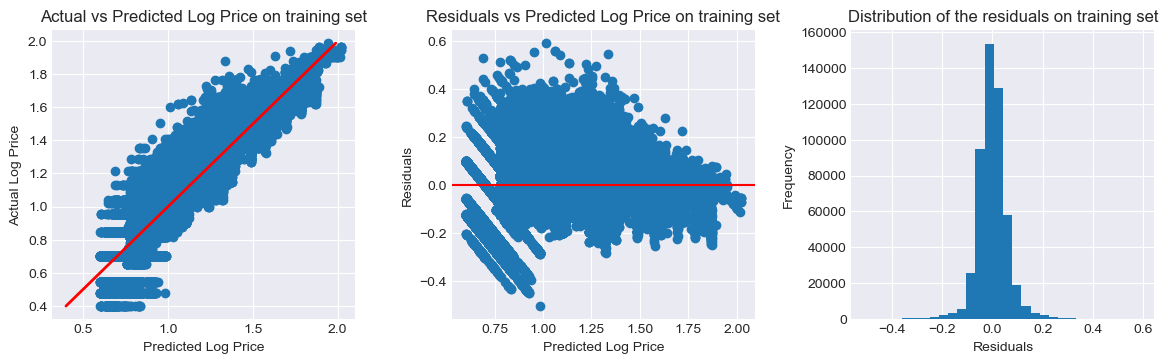

In [79]:
# Fit the model on the training data
pipe_mlr.fit(X_train, y_train)

# Get predictions and residuals
y_train_pred = pipe_mlr.predict(X_train)
residuals = y_train - y_train_pred

# Create a grid of axes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot actual vs predictors on training set to check linearity
ax[0].scatter(y_train_pred, y_train)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r", lw=2)
ax[0].set_ylabel("Actual Log Price")
ax[0].set_title("Actual vs Predicted Log Price on training set")
ax[0].set_xlabel("Predicted Log Price")

# Plot the residuals vs predicted values on training set to check Homoscedasticity
ax[1].scatter(y_train_pred, residuals)
ax[1].axhline(0, c="r")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs Predicted Log Price on training set")
ax[1].set_xlabel("Predicted Log Price")

# Plot the residuals on the training set to check Normality of Residuals
ax[2].hist(residuals, bins=30)
ax[2].set_ylabel("Frequency")
ax[2].set_xlabel("Residuals")
ax[2].set_title("Distribution of the residuals on training set")

# Avoid overlap between title and x-axis
plt.tight_layout(pad=2.0)
plt.show()

Looking at the plot on the left, above, there seems to be a reasonably linear relationship for much of the data, as points cluster near the 45-degree line. Nevertheless, the model might struggle with edge cases or certain ranges. Looking at plot the plot on the middle, below, we can see that variance of the errors (residuals) may be constant across all levels of the predicted values as we cannot observe a pattern in the chart. Looking at the plot on the right the residuals are normally distributed. So the linearity assumptions hold for our data. In the next steps, in order to look for the factors (features) that impact the price the most, we perform Permutation important and Bootstrapping techniques so we don't need to rely on the distribution of our data. 

##### 12.3 Performance on test data

In [80]:
# Predictions on test set
y_test_pred = pipe_mlr.predict(X_test)

# Calculate Test MSE and R2
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", round(test_mse, 4))
print("Test R^2:", round(test_r2, 4))

Test MSE: 0.0038
Test R^2: 0.9381


##### 12.4 Feature importance - Permutation Importance

Permutation importance is a model-agnostic method for assessing feature importance, even for linear models like multilinear regression. Calculate the drop in R2 between the original model and the permuted model (permuting dataset). A large drop in R2 indicates that the feature is important for the model's predictions, while a small drop suggests the feature is less important. In our case we can observe that for the multilinear regression the most important features, ranking by order of importance is: product_name, distance, cab_type and surge_multiplier. This result makes sense, as we saw in the EDA step, that these metrics were correlated to Price.

In [81]:
# Get Permutation importance
permutation_importances_pipe_mlr = permutation_importance(
    pipe_mlr,
    X_train,
    y_train,
    scoring="r2",
    n_repeats=15,
    random_state=random_state,
    n_jobs=n_jobs,
)

# Sort values from Permutation
sorted_importances_idx = permutation_importances_pipe_mlr.importances_mean.argsort()
df_permutation_importances_pipe_mlr = pd.DataFrame(
    permutation_importances_pipe_mlr.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

In [82]:
# Apply format_feature_name() to each column name
df_permutation_importances_pipe_mlr.columns = [
    format_feature_name(col) for col in df_permutation_importances_pipe_mlr.columns
]
df_permutation_importances_pipe_mlr.columns

Index(['Precipitation Probability', 'Temperature', 'Wind Speed', 'Month',
       'Day Of Week', 'Day', 'Hour', 'Destination', 'Source',
       'Surge Multiplier', 'Cab Type', 'Distance', 'Product Name'],
      dtype='object')

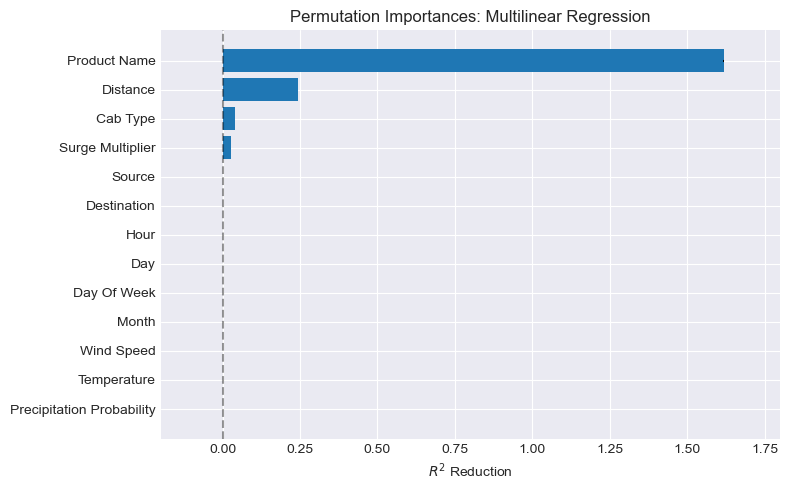

In [83]:
# Create subplot
# ax = df_permutation_importances_pipe_mlr.apply(np.log1p).plot.box(
#    vert=False, whis=10, figsize=(6, 4), widths=0.5
# )

vals = df_permutation_importances_pipe_mlr.mean(axis=0)
stds = df_permutation_importances_pipe_mlr.std(axis=0)

fig, ax = plt.subplots(tight_layout=True, figsize=(8, 5), sharey=True)
ax.set_title("Permutation Importances: Multilinear Regression")
ax.barh(y=df_permutation_importances_pipe_mlr.columns, width=vals, xerr=stds)
ax.axvline(x=0, color="k", linestyle="--", alpha=0.4)
ax.set_xlabel("$R^2$ Reduction")
ax.set_xlim([-0.2, 1.8]);

Conclusion: There is minimal difference between permuted and the original model in determining feature importance.

##### 12.5 Permutation Importance - Bootstrapping of Coefficient Values

Bootstrapping is a resampling technique that can be used to estimate the variability of the coefficients in multilinear regression, helping assess their importance. This method provides a more detailed view of the uncertainty in feature effects in addition to the magnitude of each feature. It helps to see if the feature is significant to the model and it's impact. 

The chart below provides the magnitude and sign of coefficients of the multilinear regression model with its bootstrap mean and confidence intervals. we can see that product_type (one-hot encoded) features are significant and the most important followed by distance, cab_type and surge_multiplier, destination and source. We can observe some interesting patterns such as:

**product_name features**: Each one represents a different type of ride or service (e.g., Uber Black, Lyft Shared, etc.). The coefficients for these features indicate how much more or less the price is compared to the baseline (Lift Lux).

For example:

- **product_name_Lyft_Shared** might have a negative or smaller positive coefficient, indicating that Lyft Shared rides are generally cheaper than the baseline Lift Lux.

- **product_name_Uber_BlackSUV** would likely have a larger positive coefficient, meaning that Uber BlackSUV rides tend to cost more than the baseline service (Lift Lux).

**cab_type_Uber** coefficient reflects how Uber rides compare to the baseline (Lyft) in terms of price. A positive coefficient means Uber rides are generally more expensive than Lyft.

- **distance:** positive coefficient for distance means that as the distance of the ride increases, the price also increases. This is intuitive, as longer rides usually incur higher costs.

- **surge_multiplier:** A positive coefficient for surge_multiplier indicates that as the surge multiplier increases (usually during peak demand times), the price also increases. Surge pricing is typically applied when demand is high, resulting in a higher cost for the ride.

- **destination** and **source** features show how the starting and ending locations impact the price, with certain locations driving higher or lower costs.


for example:

- **destination_Theatre_District** have a higher positive coefficient, indicating that rides to the Theatre District generally result in higher prices.

- **source_South_Station** have a higher positive coefficient, indicating that rides originating from Boston University tend to have higher prices.

In [84]:
# Define the number of bootstrap iterations
n_boots = 100

# Lists to save coefficients
boot_betas = []

np.random.seed(42)  # For reproducibility

# Bootstrap loop
for i in range(n_boots):
    # Randomly sample indices with replacement to create bootstrap samples
    boot_i = np.random.choice(X_train.index, replace=True, size=len(X_train.index))

    # Create bootstrap datasets for features and target variable using the sampled indices
    X_train_boot = X_train.loc[boot_i]
    y_train_boot = y_train.loc[boot_i]

    # Train the pipeline on the bootstrap sample
    boot_pipe_mlr = Pipeline(
        steps=pipe_mlr.steps
    )  # Clone the pipeline to avoid overwriting
    boot_pipe_mlr.steps[-1] = ("regressor", clone(boot_pipe_mlr.steps[-1][-1]))
    boot_pipe_mlr.fit(X_train_boot, y_train_boot)

    # Extract and save coefficients from the trained pipeline
    regressor = boot_pipe_mlr.named_steps["regressor"]
    preprocessor = boot_pipe_mlr.named_steps["preprocessor"]

    # Intercept and coefficients
    intercept = regressor.intercept_
    coefficients = regressor.coef_

    # Save the coefficients (intercept + feature coefficients)
    boot_betas.append(np.insert(coefficients, 0, intercept))

# Convert bootstrap coefficients to a NumPy array for further analysis
boot_betas = np.array(boot_betas)

In [85]:
# Extract feature names
numeric_features_transformed = numerical_features
categorical_features_transformed = preprocessor.named_transformers_[
    "cat"
].get_feature_names_out(categorical_features)
all_features = np.concatenate(
    [numeric_features_transformed, categorical_features_transformed]
)

# Store betas in df with feature names
feature_names_final = ["intercept"] + list(all_features)
boot_betas_df = pd.DataFrame(boot_betas, columns=feature_names_final)
boot_betas_df.head()

,intercept,distance,surge_multiplier,temperature,precipitationProbability,windSpeed,hour_1,hour_2,hour_3,hour_4,...,product_name_Uber_UberPool,product_name_Uber_UberX,product_name_Uber_UberXL,product_name_Uber_WAV,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,1.227028,0.086185,0.028931,0.000087,-0.000145,0.000105,0.000459,0.000347,0.000991,0.000422,...,-0.221266,-0.174351,0.027265,-0.173931,-0.000586,-0.000066,-0.000603,-0.000546,-0.000152,0.000418
1,1.228614,0.086161,0.029098,0.000398,0.000244,0.000008,-0.000871,-0.000844,-0.000802,-0.000573,...,-0.221047,-0.174481,0.027200,-0.174081,-0.000148,-0.000002,-0.000261,-0.000159,0.000301,-0.000882
2,1.229023,0.086440,0.029261,0.000224,-0.000052,0.000308,-0.000606,-0.000512,-0.000760,-0.000313,...,-0.221286,-0.174115,0.027549,-0.174564,-0.000739,-0.000100,-0.000391,-0.000061,0.000426,-0.000387
3,1.227900,0.086389,0.029342,0.000022,0.000068,0.000180,-0.001274,-0.000423,0.000395,-0.000083,...,-0.221357,-0.174260,0.027190,-0.174162,-0.000266,0.000089,-0.000396,-0.000398,-0.000287,0.000271
4,1.227510,0.086419,0.028842,-0.000120,0.000067,0.000016,0.000675,0.000692,0.000578,0.000354,...,-0.220581,-0.174502,0.027439,-0.174888,-0.000306,0.000012,-0.000356,-0.000455,-0.000654,0.000055


In [86]:
# Initialize an empty list to store statistics for each feature
stats_list = []

# Loop through each feature to compute its bootstrapped statistics
for i in range(len(feature_names_final)):

    # Extracting the bootstrapped coefficient values for the current feature
    betavals = boot_betas_df.iloc[:, i]

    # Sorting the coefficient values to aid in percentile calculation
    betavals.values.sort()

    # Calculating the 2.5th percentile - lower bound of the 95% CI
    # your code here
    x1 = np.round(np.percentile(betavals, 2.5), 2)

    # Calculating the 97.5th percentile - upper bound of the 95% CI
    x2 = np.round(np.percentile(betavals, 97.5), 2)

    # Calculating mean and standard deviation of the bootstrapped coefficients
    mean = np.round(np.mean(betavals), 2)
    std = np.round(np.std(betavals), 2)

    # Appending computed statistics for current feature to the stats_list
    stats_list.append([feature_names_final[i], mean, std, x1, x2])

# Convert the stats_list into a dataframe for easy visualization and analysis
boot_beta_df = pd.DataFrame(
    stats_list, columns=["feature", "boot_mean", "boot_std", "95_low", "95_high"]
)

# Display the final dataframe with bootstrapped statistics and confidence intervals
boot_beta_df.head()

,feature,boot_mean,boot_std,95_low,95_high
0,intercept,1.23,0.0,1.23,1.23
1,distance,0.09,0.0,0.09,0.09
2,surge_multiplier,0.03,0.0,0.03,0.03
3,temperature,0.00,0.0,-0.00,0.00
4,precipitationProbability,0.00,0.0,-0.00,0.00


In [87]:
# Apply the format_column_name function to each value in the 'feature'
boot_beta_df["feature"] = boot_beta_df["feature"].apply(format_feature_name)
boot_beta_df.head()

,feature,boot_mean,boot_std,95_low,95_high
0,Intercept,1.23,0.0,1.23,1.23
1,Distance,0.09,0.0,0.09,0.09
2,Surge Multiplier,0.03,0.0,0.03,0.03
3,Temperature,0.00,0.0,-0.00,0.00
4,Precipitation Probability,0.00,0.0,-0.00,0.00


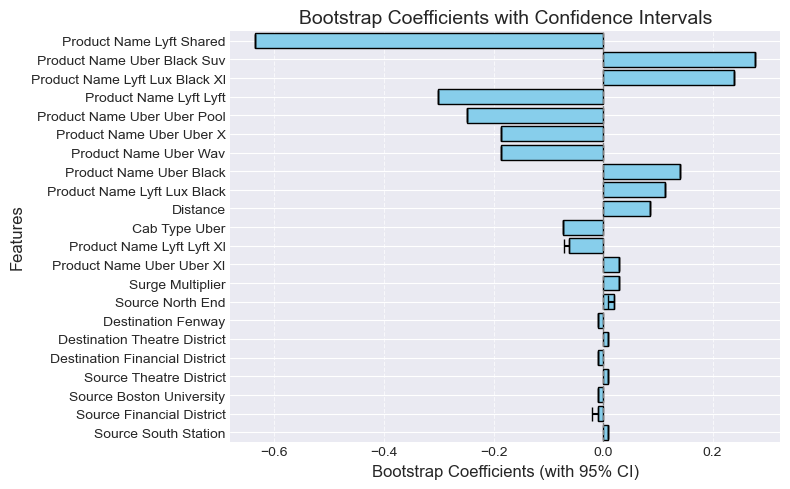

In [88]:
# Exclude the intercept
boot_beta_df_no_intercept = boot_beta_df[boot_beta_df["feature"] != "Intercept"]
# Exclude features with 95% CI cross 0
boot_beta_df_no_intercept = boot_beta_df_no_intercept[
    (boot_beta_df_no_intercept["95_low"] > 0)
    | (boot_beta_df_no_intercept["95_high"] < 0)
]

# Sort by the absolute value of bootstrap means
sorted_indices = np.argsort(
    -boot_beta_df_no_intercept["boot_mean"].abs()
)  # Sort descending by absolute value
sorted_features = boot_beta_df_no_intercept.iloc[sorted_indices]

# Extract sorted values for plotting
features = sorted_features["feature"]
boot_means = sorted_features["boot_mean"]
ci_low = sorted_features["95_low"]
ci_high = sorted_features["95_high"]

# Calculate error bars (distance from mean to bounds of confidence interval)
error_bars = [boot_means - ci_low, ci_high - boot_means]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(
    features,
    boot_means.apply(np.log1p),
    xerr=error_bars,
    color="skyblue",
    capsize=5,
    edgecolor="black",
)

# Add labels and title
plt.xlabel("Bootstrap Coefficients (with 95% CI)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Bootstrap Coefficients with Confidence Intervals", fontsize=14)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)  # Line at x=0
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Remove extra space at top and bottom
plt.ylim(-0.5, len(boot_beta_df_no_intercept) - 0.5)

# Reverse the y-axis for top-to-bottom ordering
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

##### 12.6 Conclusions

| **Variable**       | **Category**                                  | **Correlation** | **Interpretation**                                                                                     |
|---------------------|-----------------------------------------------|-----------------|---------------------------------------------------------------------------------------------------------|
| **Product Name**    | Uber Black SUV, Lyft Lux Black XL, Uber Black, Lyft Lux Black, UberXL | Positive        | Uber Black SUV, Lyft Lux Black XL, Uber Black, Lyft Lux Black, and UberXL are more expensive than Lyft Lux (baseline). |
| **Distance**        | -                                             | Positive        | Longer distances increase the price.                                                                   |
| **Cab Type**        | Uber                                          | Negative        | Uber rides tend to be cheaper than Lyft rides (baseline).                                              |
| **Surge Multiplier**| -                                             | Positive        | Higher surge multipliers increase price.                                                               |
| **Source**          | North End, Theatre District, South Station    | Positive        | Prices tend to be higher when originating from North End, Theatre District, and South Station than Back Bay. |
|                     | Financial District, Boston University         | Negative        | Prices tend to be lower when originating from Financial District and Boston University than Back Bay.  |
| **Destination**     | Theatre District                              | Positive        | Trips ending in the Theatre District tend to cost more than Back Bay.                                  |
|                     | Financial District, Fenway                   | Positive        | Trips ending in the Financial District and Fenway tend to cost more than Back Bay.                     |


##### 12.7 Strengths, Limitations and Future improvements

**Strengths:** 
 
- High Performance: R2 for train and test datasets indicate strong predictive power and good generalization.
- Simplicity & Interpretability: Easy to understand, with clear relationships between features and ‘Price’.


**Limitations:**
 
- Potential For Non-Linearity: the performance of the polynomial model suggests there may be minor non-linear relationships not captured. 
- Sensitive to Outliers: Extreme values can skew predictions -  this is unlikely given the stability of ride-share business model and the algorithmic pricing.

**Future improvements:**

- Polynomial regression: Explore and hyperparameter tuning to improve performance
- Outlier: Implement method for outlier detection 

#### 13. Appendix

##### 13.1 Final dataset details:

The Numerical features are:
- `distance`: Total distance covered during the ride from the pick-up point to the drop-off point in miles (mi)            
- `surge_multiplier`: Multiplier to increase the price based on supply-demand
- `temperature`: Ambient temperature in Boston at the time of the ride in Fahrenheit
- `windSpeed`: Wind speed in Boston at the time of the ride in miles per hour (mph)     
- `precipitationProbability`: The likelihood of precipitation falling in a particular area over a defined period of time
   

The Categorical features are:
- `hour`: Hour of the day  
- `day`: Day of the month when the ride was done
- `day_of_week`: Day of the week (7 unique values - Monday=0 and Sunday=6: 0, 1, 2, 3, 4, 5, 6)
- `month`: Month in a year (2 unique values: 11 and 12)
- `source`: Initial source of the ride (12 unique values: 'Haymarket Square', 'Back Bay', 'North End', 'North Station', 'Beacon Hill', 'Boston University', 'Fenway', 'South Station', 'Theatre District', 'West End', 'Financial District', 'Northeastern University')
- `destination`: Destination of the ride (12 unique values: 'North Station', 'Northeastern University', 'West End', 'Haymarket Square', 'South Station', 'Fenway', 'Theatre District', 'Beacon Hill', 'Back Bay', 'North End', 'Financial District', 'Boston University')
- `cab_type`: The type of cab (2 unique values: Uber, Lyft),
- `product_name`: Name of the product (13 unique values: 'Lift_Shared', 'Lift_Lux', 'Lift_Lyft', 'Lyft_Lux Black XL', 'Lyft_Lyft XL', 'Lyft_Lux Black', 'Uber_UberXL', 'Uber_Black', 'Uber_UberX', 'Uber_WAV', 'Uber_Black SUV', 'Uber_UberPool')


The (Numerical) outcome is:
- `price`: Price of the trip/ride (for modeling purposes we use the log of price)

In [89]:
notebook_end = time.time()
print(
    f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run"
)

It took 25.96 minutes for this notebook to run
